## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [5]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt



def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def BandpassFilter(signal, pass_band):
    '''
    from fourier_transform_II exercise of Intro Digital sampling and Signal Processing
    receive a signal and return band pass filter of it
    
    # fs 125 Hz as per troika dataset readme
    '''
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=125)
    return sp.signal.filtfilt(b, a, signal)


def CalcSNR(sig, hr_bpm=0):
    '''
    from 3-ppg-snr exercise of Intro Sensors
    
    receive a signal and heart rate and return noise ratio
        '''
    
    # data is sampled at 125 Hz as per troika dataset readme
    fs = 125
    #convert hr_bpm to HZ
    hr_f = hr_bpm / 60

    #calculate frequency of 1st harmonic
    harmonic_f = hr_f * 2

    #compute fft
    freqs=np.fft.rfftfreq(len(sig),1/fs)
    fft_mag=np.abs(np.fft.rfft(sig,len(sig)))

    #find frequency around heart heat and 1st harmonic
    window_f=40/60 #40bpm in hz
    fundamental_frequency_window = (freqs > hr_f - window_f) & (freqs < hr_f + window_f)
    harmonic_frequency_window = (freqs > harmonic_f - window_f) & (freqs < harmonic_f + window_f)

    # Compute signal power and noise power
    signal_power = np.sum(fft_mag[(fundamental_frequency_window) | (harmonic_frequency_window)])
    noise_power = np.sum(fft_mag[~((fundamental_frequency_window) | (harmonic_frequency_window))])
    #signal_power = np.sum(fft_mag[(fundamental_frequency_window)])
    #noise_power = np.sum(fft_mag)

    # Compute SNR
    snr = signal_power / noise_power
    return snr, freqs, fft_mag


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    
    #estimates pulse rate from the PPG signal and a 3-axis accelerometer.
    #assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM
    #produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.
    #produces an output at least every 2 seconds.
   
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    #based on readme file BMP0 field has the ground truth
    reference_label = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    #pulse rate restricted between 40BPM (beats per minute) and 240BPM
    ppg_filtered = BandpassFilter(ppg, (40/60,240/60))
    accx_filtered = BandpassFilter(accx, (40/60,240/60))
    accy_filtered = BandpassFilter(accy, (40/60,240/60))
    accz_filtered = BandpassFilter(accz, (40/60,240/60))
    #acc_all_filtered = np.sqrt(accx_filtered**2 + accy_filtered**2 + accz_filtered**2)
    # Compute pulse rate estimates and estimation confidence.

    time_window = 8*125 #8s time as per troika readme  X fs
    time_interval = 2*125 #2s time as per project requirement  X fs
    
    inferences = []
    snrs = []
    
    for r in range(0, len(ppg_filtered)- time_window +1, time_interval):
        r_final=r+time_window
        ppg_range = ppg_filtered[r:r_final]
        accx_range = accx_filtered[r:r_final]
        accy_range = accy_filtered[r:r_final]
        accz_range = accz_filtered[r:r_final]
        #acc_range = acc_all_filtered[r:r_final]
        
        #get freq and fft_mag for signal
        _, ppg_filtered_freq, ppg_filtered_mag = CalcSNR(ppg_range)
        _, accx_freq, accx_mag = CalcSNR(accx_range)
        _, accy_freq, accy_mag = CalcSNR(accy_range)
        _, accz_freq, accz_mag = CalcSNR(accz_range)
        
        acc_all_mag = np.sqrt(accx_mag**2 + accy_mag**2 + accz_mag**2)
        
        #data wihtin 40-240 hz
        ppg_filtered_freq = ppg_filtered_freq[(ppg_filtered_freq>40/60) & (ppg_filtered_freq<240/60)]
        #acc_all_filtered_freq = acc_all_filtered_freq[(acc_all_filtered_freq>40/60) & (acc_all_filtered_freq<240/60)]
        ppg_filtered_mag = ppg_filtered_mag[(ppg_filtered_freq>40/60) & (ppg_filtered_freq<240/60)]
        #acc_all_filtered_mag = acc_all_filtered_mag[(acc_all_filtered_freq>40/60) & (acc_all_filtered_freq<240/60)]        
        
        #find peaks
        ppg_filtered_pks = sp.signal.find_peaks(ppg_filtered_mag)[0]
        acc_all_pks = sp.signal.find_peaks(acc_all_mag)[0]
        
        #data wihtin 40-240 hz
        #ppg_filtered_pks = ppg_filtered_pks[(ppg_filtered_pks>40/60) & (ppg_filtered_pks<240/60)]
        #acc_all_pks = acc_all_pks[(acc_all_pks>40/60) & (acc_all_pks<240/60)]
        
        
        #order descending of pks
        ppg_pks = -np.sort(-ppg_filtered_pks)
        acc_pks = -np.sort(-acc_all_pks)
        
        #check if pk value is at accelerometer. if it is, try next. if all exists return 1st one
        p=0
        #if(len(ppg_pks)>0):
        while ppg_pks[p] in acc_pks:
            p+=1
            if(p==len(ppg_pks)):
                p=0
                break

        #get highest
        ppg_pk = ppg_filtered_freq[ppg_pks[p]]
        #else:
        #    ppg_filtered_freq
        #get snr
        snr, _,_ = CalcSNR(ppg_filtered_freq,ppg_pk)
        #window = (ppg_filtered_freq > ppg_pk - (40/60)) & (ppg_filtered_freq < ppg_pk + (40/60))  
        #snr = np.sum(ppg_filtered_mag[window]) / np.sum(ppg_filtered_mag)

        #predicted/inferenced valued
        inferences.append(ppg_pk*60)
        snrs.append(snr)
    
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.abs(np.subtract(inferences, reference_label)), snrs  # Dummy placeholders. Remove
    return errors, confidence


In [6]:
Evaluate()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:183: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 501 but corresponding boolean dimension is 26


60.264048559444667

In [4]:
data_fls,ref_fls = LoadTroikaDataset()

In [3]:
data_fls#signal data

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [4]:
ref_fls#reference data

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

In [5]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [6]:
ppg

array([   4. ,    6. ,    3. , ...,   86. ,  104. ,  118.5])

In [7]:
accx

array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134])

In [8]:
accy

array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ])

In [9]:
accz

array([ 0.9594,  0.9438,  0.936 , ...,  0.7254,  0.7176,  0.7254])

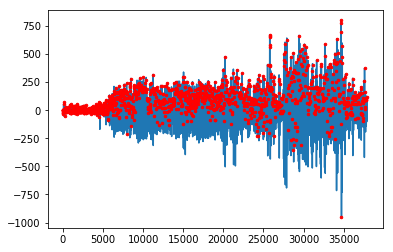

In [80]:
#PPG peaks - 2-ppg-peaks exercise from Intro to Sensors
pks, r = sp.signal.find_peaks(ppg)
plt.plot(ppg_filtered)
plt.plot(pks,ppg_filtered[pks], 'r.', ms=5)

In [105]:
-np.sort(-pks)[:5]

array([37888, 37838, 37787, 37776, 37747])

In [10]:
#average pulse
np.mean(60/(np.diff(pks)/125))

NameError: name 'pks' is not defined

In [14]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
#based on readme file BMP0 field has the ground truth
reference_label = sp.io.loadmat(ref_fls[0])['BPM0'] 
#pulse rate restricted between 40BPM (beats per minute) and 240BPM
ppg_filtered = BandpassFilter(ppg, (40/60,240/60))
accx_filtered = BandpassFilter(accx, (40/60,240/60))
accy_filtered = BandpassFilter(accy, (40/60,240/60))
accz_filtered = BandpassFilter(accz, (40/60,240/60))
acc_all_filtered = np.sqrt(accx_filtered**2 + accy_filtered**2 + accz_filtered**2)
# Compute pulse rate estimates and estimation confidence.

time_window = 8*125 #8s time as per troika readme  X fs
time_interval = 2*125 #2s time as per project requirement  X fs

#for r in range(0, len(ppg_filtered)- time_window, time_interval):
#    r_final=r+time_window

ppg_range = ppg_filtered[0:1000]
acc_range = acc_all_filtered[0:1000]

_, ppg_filtered_freq, ppg_filtered_mag = CalcSNR(ppg_range)
_, acc_all_filtered_freq, acc_all_filtered_mag = CalcSNR(acc_range)


#data wihtin 40-240 hz
#ppg_filtered_freq = ppg_filtered_freq[(ppg_filtered_freq>=40/60) & (ppg_filtered_freq<=240/60)]
#acc_all_filtered_freq = acc_all_filtered_freq[(acc_all_filtered_freq>=40/60) & (acc_all_filtered_freq<=240/60)]
#ppg_filtered_mag = ppg_filtered_mag[(ppg_filtered_freq>=40/60) & (ppg_filtered_freq<=240/60)]
#acc_all_filtered_mag = acc_all_filtered_mag[(acc_all_filtered_freq>=40/60) & (acc_all_filtered_freq<=240/60)]

ppg_filtered_pks = sp.signal.find_peaks(ppg_filtered_mag)[0]
acc_all_filtered_pks = sp.signal.find_peaks(acc_all_filtered_mag)[0]

#higher fft value used as reference to get acc value as well
#ppg_filtered_high = ppg_filtered_freq[np.argmax(ppg_filtered_freq)]
#acc_all_filtered_high = acc_all_filtered_freq[np.argmax(acc_all_filtered_freq)]

#get 5 highest pks
ppg_pks = -np.sort(-ppg_filtered_pks)[:5]
acc_pks = -np.sort(-acc_all_filtered_pks)[:5]

#check if pk value is at accelerometer
p=0
while ppg_pks[p] in acc_pks:
    p+=1
ppg_pk = ppg_filtered_freq[ppg_pks[p]]

#get snr
snr, _,_ = CalcSNR(ppg_filtered_freq,ppg_pk)

print(ppg_pk*60)
print(reference_label[int(0/(125*2))])
print(np.abs(ppg_pk*60 - reference_label[int(0/(125*2))]))

307.5
[ 74.33920705]
[ 233.16079295]


In [132]:
ppg_filtered_freq.shape

(27,)

In [133]:
ppg_filtered_mag.shape

(27,)

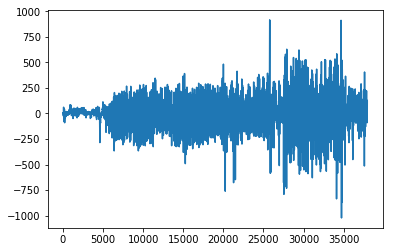

In [12]:
plt.plot(ppg)

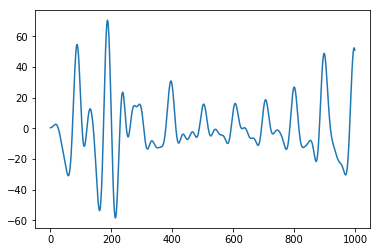

In [14]:
plt.plot(ppg_filtered[0:1000])

In [31]:
signal=ppg_filtered[0:1000]
n_samples = len(signal)  # No zero padding
freqs = np.fft.rfftfreq(n_samples, 1/125)
fft = np.abs(np.fft.rfft(signal))

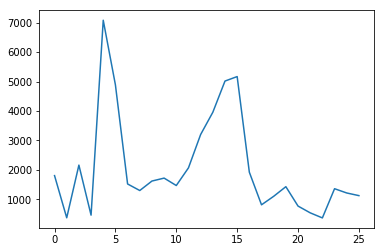

In [23]:
plt.plot(fft[(freqs>40/60) & (freqs<240/60)])

In [32]:
filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filtered_ppg, NFFT = (8*125), Fs=125, noverlap=noverlap)
    plt.close()

(501,)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 